In [2]:
import os
import re
import json
from datetime import datetime
import time
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

import tqdm
import requests
from pydantic import BaseModel, HttpUrl
import pandas as pd
from dotenv import load_dotenv
import tiktoken
from openai import OpenAI

load_dotenv()

True

In [14]:
class Article(BaseModel):
    pocket_item_id: int
    given_url: HttpUrl
    resolved_url: HttpUrl
    title: str
    time_added: datetime
    word_count: int
    domain: str
    text: str | None = None
    summary: str | None = None
    summary_attempted_message: str | None = None

## 1. List of likes articles


### a. From Pocket


In [15]:
POCKET_HEADERS = {
    "Content-Type": "application/json; charset=UTF8",
    "X-Accept": "application/json",
}
POCKET_CONSUMER_KEY = os.getenv("POCKET_CONSUMER_KEY")

#### Authorize


Skip to `Read from .env file` if you have authorized previously. Otherwise:


In [ ]:
data = {"consumer_key": POCKET_CONSUMER_KEY, "redirect_uri": "https://127.0.0.1"}
url = "https://getpocket.com/v3/oauth/request"
r = requests.request("Post", url=url, headers=POCKET_HEADERS, json=data)
# {"code": "abcd-1234-abcd-1234", 'state': None}

POCKET_CODE = r.json()["code"]

Replace `your-code` in the following url with the code value you get, and open the url in your browser, grant access, close the tab, then get back here and run the next cell to get access token:

https://getpocket.com/auth/authorize?request_token=your-code&redirect_uri=https://127.0.0.1


In [ ]:
data = {"consumer_key": POCKET_CONSUMER_KEY, "code": POCKET_CODE}
url = "https://getpocket.com/v3/oauth/authorize"
r = requests.request("Post", url=url, headers=POCKET_HEADERS, json=data)
# {"access_token": "efgh-1234-efgh-1234", "username": "your-username"}

POCKET_ACCESS_TOKEN = r.json()["access_token"]

Add the `access_token` to `.env` file, so you can skip the authorization steps above next times and just use the following:


#### Read from `.env` file


In [16]:
POCKET_ACCESS_TOKEN = os.getenv("POCKET_ACCESS_TOKEN")

In [6]:
def get_pocket_items(state: str = "archive") -> list[Article]:
    """
    Get all items archive in pocket
    """
    pocket_items = []
    count = 500
    offset = 0
    while True:
        payload = {
            "consumer_key": POCKET_CONSUMER_KEY,
            "access_token": POCKET_ACCESS_TOKEN,
            "state": state,
            "sort": "newest",
            "count": count,
            "offset": offset,
            "detailType": "complete",
            "total": "1",  ## total number of archived articles
        }

        url = "https://getpocket.com/v3/get"
        r = requests.request("Post", url=url, headers=POCKET_HEADERS, json=payload)

        for item in r.json()["list"]:
            pocket_item = r.json()["list"][item]
            try:
                pocket_items.append(
                    Article(
                        pocket_item_id=int(pocket_item["item_id"]),
                        given_url=pocket_item["given_url"],
                        resolved_url=pocket_item["resolved_url"],
                        title=pocket_item["resolved_title"],
                        time_added=datetime.fromtimestamp(
                            int(pocket_item["time_added"])
                        ),
                        word_count=int(pocket_item["word_count"]),
                        domain=pocket_item.get("domain_metadata", {}).get("name", ""),
                    )
                )
            except Exception as e:
                print(f"Error processing item {pocket_item['item_id']}: {e}")
                continue

        if int(r.json()["total"]) > count + offset:
            print(f"Fetching more articles... {count + offset} / {r.json()['total']}")
            offset += count
        else:
            print(f"Fetched {offset + count} articles")
            break

    return pocket_items


pocket_items = get_pocket_items()
print(len(pocket_items))
pocket_items[0]

Fetching more articles... 500 / 3692
Fetching more articles... 1000 / 3692
Fetching more articles... 1500 / 3692
Fetching more articles... 2000 / 3692
Error processing item 3945908435: 1 validation error for Article
resolved_url
  Input should be a valid URL, input is empty [type=url_parsing, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/url_parsing
Fetching more articles... 2500 / 3692
Fetching more articles... 3000 / 3692
Fetching more articles... 3500 / 3692
Fetched 4000 articles
3691


Article(pocket_item_id=5598506, given_url=HttpUrl('https://nat.org/'), resolved_url=HttpUrl('http://nat.org/'), title='Nat Friedman', time_added=datetime.datetime(2025, 1, 15, 11, 20, 58), word_count=451, domain='nat.org')

In [11]:
df = pd.DataFrame([article.model_dump() for article in pocket_items])
df.to_csv("pocket_articles.csv", index=False)
df.head()

,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net
2,132470062,https://www.kalzumeus.com/2012/01/23/salary-ne...,https://www.kalzumeus.com/2012/01/23/salary-ne...,"Salary Negotiation: Make More Money, Be More V...",2024-11-15 12:07:03,6794,www.kalzumeus.com
3,172658679,https://stevehanov.ca/blog/index.php?id=132,http://stevehanov.ca/blog/index.php?id=132,20 lines of code that will beat A/B testing ev...,2025-01-15 00:24:49,970,stevehanov.ca
4,210539245,https://digital-photography-school.com/6-reaso...,https://digital-photography-school.com/6-reaso...,9 Reasons Why Photography Matters,2024-12-02 23:13:34,2312,Digital Photography School


### b. From csv file


In [3]:
# df = pd.read_csv("pocket_articles.csv")
df = pd.read_csv("pocket_articles_with_text.csv")
df.head()

,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e..."
2,132470062,https://www.kalzumeus.com/2012/01/23/salary-ne...,https://www.kalzumeus.com/2012/01/23/salary-ne...,"Salary Negotiation: Make More Money, Be More V...",2024-11-15 12:07:03,6794,www.kalzumeus.com,"Title: Salary Negotiation: Make More Money, Be..."
3,172658679,https://stevehanov.ca/blog/index.php?id=132,http://stevehanov.ca/blog/index.php?id=132,20 lines of code that will beat A/B testing ev...,2025-01-15 00:24:49,970,stevehanov.ca,Title: 20 lines of code that will beat A/B tes...
4,210539245,https://digital-photography-school.com/6-reaso...,https://digital-photography-school.com/6-reaso...,9 Reasons Why Photography Matters,2024-12-02 23:13:34,2312,Digital Photography School,Title: 9 Reasons Why Photography Matters\n\nUR...


In [4]:
df = df.replace({float("nan"): None})
pocket_items = [Article(**row) for _, row in df.iterrows()]

## Extract texts using `r.jina.ai`


I will use [Jina Reader](https://jina.ai/reader/) to extract the text of the saved articles. Its free API is limited to 20 requests per minute, but you can pay and use an API key to get 200 requests per minute limit. Visit [their website](https://jina.ai/) to get an API key.


In [18]:
JINA_API_KEY = os.getenv("JINA_API_KEY")

In [25]:
def get_url_text(url: str) -> str:
    request_url = f"https://r.jina.ai/{url}"
    headers = {"Authorization": f"Bearer {JINA_API_KEY}", "X-No-Cache": "true"}
    r = requests.get(request_url, headers=headers)

    if r.status_code == 402:
        raise Exception("Token limit reached.")
    if r.status_code != 200:
        print(f"Error fetching {url}: {r.status_code}, sleeping for 10 seconds ...")
        time.sleep(10)
        return get_url_text(url)
    return r.text

In [22]:
## slow, but less likely to get rate limited

# for i, item in enumerate(pocket_items):
#     if item.text:
#         continue

#     item.text = get_url_text(item.resolved_url)
#     if i % 25 == 0:
#         print(f"Processed {i} articles, {len(pocket_items) - i} articles left ...")


In [24]:
## fast, but you'll get rate limited and should try again


def process_batch(items: list[tuple[int, object]], max_workers=10):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_item = {
            executor.submit(get_url_text, item.resolved_url): (i, item)
            for i, item in items
        }

        for future in tqdm.tqdm(as_completed(future_to_item), total=len(items)):
            i, item = future_to_item[future]
            try:
                item.text = future.result()
            except Exception as e:
                print(f"Error processing item {i}: {e}")


items_with_index = [(i, item) for i, item in enumerate(pocket_items) if not item.text]
process_batch(items_with_index)


0it [00:00, ?it/s]


In [23]:
df = pd.DataFrame([article.model_dump() for article in pocket_items])
df.to_csv("pocket_articles_with_text.csv", index=False)
df.head()

,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e..."
2,132470062,https://www.kalzumeus.com/2012/01/23/salary-ne...,https://www.kalzumeus.com/2012/01/23/salary-ne...,"Salary Negotiation: Make More Money, Be More V...",2024-11-15 12:07:03,6794,www.kalzumeus.com,"Title: Salary Negotiation: Make More Money, Be..."
3,172658679,https://stevehanov.ca/blog/index.php?id=132,http://stevehanov.ca/blog/index.php?id=132,20 lines of code that will beat A/B testing ev...,2025-01-15 00:24:49,970,stevehanov.ca,Title: 20 lines of code that will beat A/B tes...
4,210539245,https://digital-photography-school.com/6-reaso...,https://digital-photography-school.com/6-reaso...,9 Reasons Why Photography Matters,2024-12-02 23:13:34,2312,Digital Photography School,Title: 9 Reasons Why Photography Matters\n\nUR...


In [4]:
## if already saved
df = pd.read_csv("pocket_articles_with_text.csv")
print(df.shape)
df.head(2)

(3691, 8)


,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e..."


In [ ]:
from tqdm.notebook import tqdm_notebook


def count_tokens(text: str) -> int:
    ## using gpt-4o tokenizer just to get an estimate
    return len(tiktoken.encoding_for_model("gpt-4o").encode(text))


tqdm_notebook.pandas()
df["token_count"] = df["text"].progress_apply(count_tokens)
df.head()
# df.to_csv("pocket_articles_with_text_and_token_count.csv", index=False)


/var/folders/91/9ftjbh9516n335fl5bxhw12w0000gn/T/ipykernel_17426/3573386153.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


  0%|          | 0/3691 [00:00<?, ?it/s]

,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text,token_count
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....,714
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e...",3092
2,132470062,https://www.kalzumeus.com/2012/01/23/salary-ne...,https://www.kalzumeus.com/2012/01/23/salary-ne...,"Salary Negotiation: Make More Money, Be More V...",2024-11-15 12:07:03,6794,www.kalzumeus.com,"Title: Salary Negotiation: Make More Money, Be...",9507
3,172658679,https://stevehanov.ca/blog/index.php?id=132,http://stevehanov.ca/blog/index.php?id=132,20 lines of code that will beat A/B testing ev...,2025-01-15 00:24:49,970,stevehanov.ca,Title: 20 lines of code that will beat A/B tes...,98248
4,210539245,https://digital-photography-school.com/6-reaso...,https://digital-photography-school.com/6-reaso...,9 Reasons Why Photography Matters,2024-12-02 23:13:34,2312,Digital Photography School,Title: 9 Reasons Why Photography Matters\n\nUR...,3560


total 13,032,360
count      3691.000000
mean       3530.848009
std        8088.208652
min          15.000000
25%        1170.500000
50%        2137.000000
75%        4030.500000
max      310254.000000
Name: token_count, dtype: float64


<Axes: >

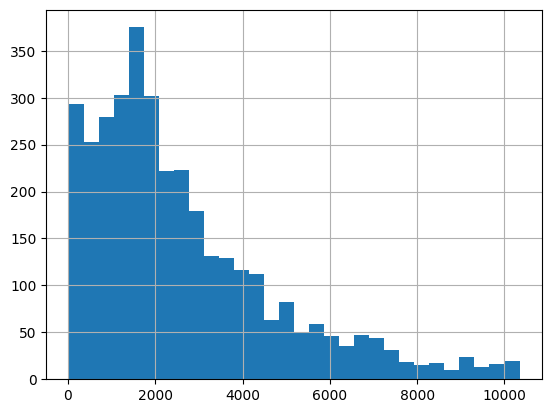

In [13]:
total_tokens = df["token_count"].sum()
print(f"total {total_tokens:,}")
print(df["token_count"].describe())
df[df["token_count"] < df["token_count"].quantile(0.95)]["token_count"].hist(bins=30)

## Summarize texts


In [15]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

df = pd.read_csv("pocket_articles_with_summary.csv")
df = df.replace({float("nan"): None})
pocket_items = [Article(**row) for _, row in df.iterrows()]
df.head(2)

,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text,summary
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....,"I'm an investor, entrepreneur, and developer w..."
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e...",Advising Ph.D. students often involves teachin...


We will use Google Gemini model with OpenAI Python SDK to summarize text into a few paragraphs:

In [64]:
llm_client = OpenAI(
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
    api_key=os.getenv("GEMINI_API_KEY")
)


def summarize_text(text: str) -> str:
    try:
        completion = llm_client.chat.completions.create(
            model="gemini-2.0-flash",
            messages=[
                {
                    "role": "system",
                    "content": "Summarize the provided text in 2-5 paragraphs, maintaining the original author's first-person perspective and voice. The summary should read as if the original author wrote it themselves as a condensed version of their full text. Return the summary between <summary> and </summary> tags.",
                },
                {"role": "user", "content": f"<text>{text}</text>"},
            ],
        )
        summary = re.search(
            r"<summary>(.*?)</summary>",
            completion.choices[0].message.content,
            re.DOTALL,
        )
        if summary:
            return True, summary.group(1)
        else:
            return False, completion.choices[0].message.content
    except Exception as e:
        print(f"summary error: {e}, sleeping for 30 seconds ...")
        time.sleep(30)
        return None, None


summary = summarize_text(df["text"].iloc[0])
print(summary[1])


I'm Nat Friedman, an investor, entrepreneur, and developer. I've been online since '91, which I consider my real hometown. My fascination with Richard Feynman led me to MIT, and from there, I co-founded Ximian and Xamarin. Later, I served as CEO of GitHub from 2018 to 2021. Currently, I live in California and am diving into projects like reading the Herculaneum Papyri and testing Bay Area foods for plastic chemicals.

I fundamentally believe that humans have a right, maybe even a duty, to reshape the universe to our liking, and technology, which is really just knowledge, is the key. I think it’s better to raise the ceiling than the floor. Enthusiasm is critical; it fuels progress and makes tackling ambitious projects easier. Speed is also important, it forces focus and promotes learning through frequent reality checks. "Slow is fake." Remember, a week is 2% of the year.

Furthermore, I believe the efficient market hypothesis is largely incorrect. Great opportunities arise where it fai

In [61]:
for i, item in enumerate(pocket_items):
    if item.summary or item.summary_attempted_message:
        continue

    success, message = summarize_text(item.text)
    if success:
        item.summary = message
    else:
        item.summary_attempted_message = message
        
    if i % 50 == 0:
        print(f"Processed {i} urls, {len(pocket_items) - i} left ...")

In [ ]:
df = pd.DataFrame([article.model_dump() for article in pocket_items])
df["summary"] = df["summary"].str.strip()
df.to_csv("pocket_articles_with_summary.csv", index=False)
df.head(2)

138


,pocket_item_id,given_url,resolved_url,title,time_added,word_count,domain,text,summary,summary_attempted_message
0,5598506,https://nat.org/,http://nat.org/,Nat Friedman,2025-01-15 11:20:58,451,nat.org,Title: Nat Friedman\n\nURL Source: http://nat....,"I'm an investor, entrepreneur, and developer w...",None
1,42378269,https://matt.might.net/articles/shell-scripts-...,http://matt.might.net/articles/shell-scripts-f...,"3 shell scripts to improve your writing, or ""M...",2024-12-29 12:19:45,1881,matt.might.net,"Title: Kill weasel words, avoid the passive, e...",Advising Ph.D. students often involves teachin...,None
